In [8]:
import mlflow
import glob
import pandas as pd
import os
from mlflow.entities import ViewType
from mlflow.tracking import MlflowClient
from reject_anomalies import pred_baseon_threshold,make_use_reject_anomalies
from Data_preprocessing_method import apply_PCA
from Feature_engineer import remove_unwanted_col,feature_engineer_steps
from result_display import show_result

In [9]:
def search_newest_model(experiment_name,run_name):
    mlflow.set_tracking_uri("http://127.0.0.1:8080")
    experiment = mlflow.get_experiment_by_name(experiment_name)
    
    if experiment:
        experiment_id = experiment.experiment_id
        
    else:
        raise ValueError(f"Experiment named {experiment_name} not found")



    runs = mlflow.search_runs(experiment_ids=[experiment_id])
    #print(runs['tags.mlflow.runName'])
    filtered_runs = runs[(runs['tags.mlflow.runName'] == run_name) & (runs.status == 'FINISHED') ]
    #print(filtered_runs)
    if filtered_runs.empty:
        raise ValueError(f"No runs with name {run_name} found in experiment {experiment_name}")
    return filtered_runs.iloc[0]


**Influencing prediction result using rejected anomalies**

In [3]:
def update_model(model_information,rejected_list_path):
    anomalies = pd.read_csv(rejected_list_path)
    experiment_ids = model_information['experiment_id']
    client = MlflowClient()
    runs = client.search_runs(experiment_ids=experiment_ids)
    sensitivity = 0.005
    if runs:
        run_id = model_information['run_id']
        current_run = client.get_run(run_id)
        artifact_path = model_information['artifact_uri']       
        model_uri = f"{artifact_path}/mlruns"
        model = mlflow.sklearn.load_model(model_uri)
        train_threshold = model_information['params.threshold']
        #pattern = f"{artifact_path}/*.csv"
        #csv_files = glob.glob(pattern)
        if 'params.PCA_sample' in model_information:
            n_sample = int(model_information['params.PCA_sample'])
            anomalies =  apply_PCA(anomalies,5)
            sensitivity = 0.0005
        new_threshold = make_use_reject_anomalies(model,anomalies,sensitivity,float(train_threshold))

        parameters = current_run.data.params
        metrics = current_run.data.metrics
        artifact_uri = current_run.info.artifact_uri
        
        with mlflow.start_run(experiment_id=experiment_ids,run_name=model_information['tags.mlflow.runName']):
            # Log the old parameters except for the threshold
            for key, value in parameters.items():
                if key != "threshold":
                    mlflow.log_param(key, value)        
            # Log the new threshold value           
            mlflow.log_param("threshold", new_threshold)        
            # Log the old metrics
            for key, value in metrics.items():
                mlflow.log_metric(key, value)
            # Log model to the new run    
            file_list = [os.path.join(model_uri, f) for f in os.listdir(model_uri) if os.path.isfile(os.path.join(model_uri, f))]
            for file_path in file_list:
                
                mlflow.log_artifact(file_path)
        return new_threshold
    else:
        print("No runs found.")

## Demo of effect of retrain on reject anomalies

In [4]:
# prepare demo data as usual
transactions_df = pd.read_csv("data/user_demo_data.csv")
terminal_profiles_df = pd.read_csv("data/terminal_profiles_table.csv")
customer_profiles_df = pd.read_csv("data/customer_profiles_table.csv")
join_terminal = pd.merge(transactions_df, terminal_profiles_df, on='terminal_id', how='inner') #join dataset base on key value
join_customer = pd.merge(join_terminal, customer_profiles_df, on='customer_id', how='inner')
train_X,train_y = feature_engineer_steps(join_customer)
train_X = remove_unwanted_col(train_X)
train_X_PCA = apply_PCA(train_X,5)

run_id                                            1241ebe0f96f4043b57b70fbada2d142
experiment_id                                                                    2
status                                                                    FINISHED
artifact_uri                     /mnt/c/Users/Leonwu/Desktop/Master_course/COMP...
start_time                                        2024-04-12 19:35:35.850000+00:00
end_time                                          2024-04-12 19:35:38.836000+00:00
metrics.f1_socre                                                          0.889456
metrics.precision                                                         0.950659
metrics.recall                                                              0.8418
metrics.train_threshold                                                        NaN
metrics.m                                                                      NaN
params.max_features                                                            1.0
para

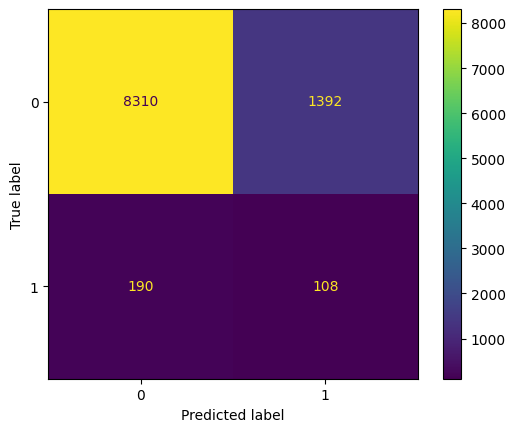

In [5]:
# get latest model from mlflow
model_info = search_newest_model("Isolation_Forest","IF_Model_PCA")
print(model_info)
train_threshold = float(model_info['params.threshold'])
artifact_path = model_info['artifact_uri']       
model_uri = f"{artifact_path}/mlruns"
model = mlflow.sklearn.load_model(model_uri)
y_pred = pred_baseon_threshold(model, train_X_PCA, train_threshold)
precision, recall, f1_socre = show_result(train_y,y_pred,"result/confusion_matrix_PCA_demo.png")

In [6]:
# update the model with reject
current_threshold = update_model(model_info,"data/reject_anomalies_sample.csv")
model_info = search_newest_model("Isolation_Forest","IF_Model_PCA")
print(model_info)

run_id                                            639685453f914f71af909c17f2330d26
experiment_id                                                                    2
status                                                                    FINISHED
artifact_uri                     /mnt/c/Users/Leonwu/Desktop/Master_course/COMP...
start_time                                        2024-04-12 19:36:06.826000+00:00
end_time                                          2024-04-12 19:36:07.340000+00:00
metrics.f1_socre                                                          0.889456
metrics.precision                                                         0.950659
metrics.recall                                                              0.8418
metrics.train_threshold                                                        NaN
metrics.m                                                                      NaN
params.max_features                                                            1.0
para

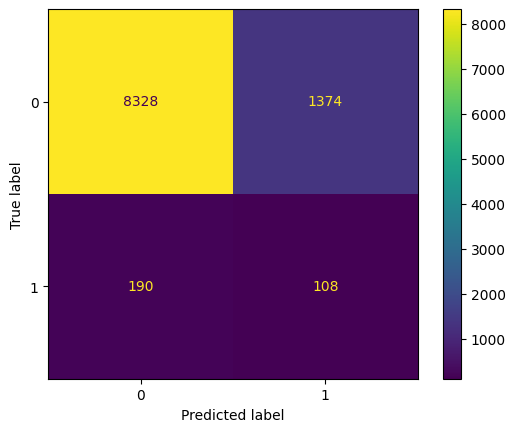

In [7]:
# get latest model from mlflow and see the result
model_info = search_newest_model("Isolation_Forest","IF_Model_PCA")
train_threshold = float(model_info['params.threshold'])
artifact_path = model_info['artifact_uri']       
model_uri = f"{artifact_path}"
model = mlflow.sklearn.load_model(model_uri)
y_pred = pred_baseon_threshold(model, train_X_PCA, train_threshold)
precision, recall, f1_socre = show_result(train_y,y_pred,"result/confusion_matrix_PCA_demo.png")